In [1]:
# Impoting required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import matplotlib.lines as mlines

# setting default option
pd.set_option("mode.copy_on_write", True)
warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
# loading the Datasets
mortality = pd.read_parquet("../../Data/processed/mortality_corrected.parquet")
shipment = pd.read_parquet("../../Data/processed/shipment_eda.parquet")

In [3]:
mortality.sample(5)

,State,State_Code,County,County_Code,Year,Deaths,Population,Mortality_Rate
9157,Oklahoma,OK,MCCURTAIN,40089,2004,4,33282.0,0.000120
11351,Texas,TX,GRAYSON,48181,2004,10,114998.0,0.000087
5977,Missouri,MO,GREENE,29077,2013,57,283750.0,0.000201
3372,Indiana,IN,MADISON,18095,2008,31,131537.0,0.000236
11442,Texas,TX,HIDALGO,48215,2004,34,653779.0,0.000052


In [4]:
shipment.sample(5)

,BUYER_STATE,BUYER_COUNTY,YEAR,MME
9146,IL,CARROLL,2006,8.019947e+05
8351,IA,WAPELLO,2017,7.450297e+06
273,AL,COVINGTON,2013,2.539334e+07
42120,WV,LINCOLN,2016,1.559360e+07
30515,PA,LAWRENCE,2018,2.750013e+07


In [5]:
# Creating control variables

# Enter the Test State Below
test_state = "TX"

# Enter list of states required below, Included the test state
state_list = ["NM", "TX", "LA", "AR", "OK", "MS", "AL", "AZ", "FL"]

# Year control variable
policy_year = 2007  # year the policy was implemented
start_year = 2003  # desired start year for analysis
end_year = 2011  # desired end year for analysis

In [6]:
# subset the data
mortality = mortality[mortality["State_Code"].isin(state_list)]
mortality = mortality[
    (mortality["Year"] >= start_year) & (mortality["Year"] <= end_year)
]

In [7]:
# check number of times each county appears in the data
mortality["County_Code"].value_counts().value_counts()

count
9    220
Name: count, dtype: int64

In [8]:
# Add columns to tag the rows for pre-post policy implementation and test-control

# Tagging the rows for pre-post policy implementation
mortality["policy_implementation"] = mortality["Year"] >= policy_year

# Tagging the rows for test-control
mortality["State_Type"] = mortality["State_Code"].apply(
    lambda x: "Test" if x == test_state else "Control"
)

In [9]:
mortality.sample(5)

,State,State_Code,County,County_Code,Year,Deaths,Population,Mortality_Rate,policy_implementation,State_Type
1833,Florida,FL,NASSAU,12089,2003,7,62069.0,0.000113,False,Control
9002,Oklahoma,OK,CANADIAN,40017,2005,14,99176.0,0.000141,False,Control
4493,Louisiana,LA,LIVINGSTON,22063,2011,42,129858.0,0.000323,True,Control
1618,Florida,FL,COLUMBIA,12023,2009,17,67412.0,0.000252,True,Control
11748,Texas,TX,TAYLOR,48441,2011,15,132867.0,0.000113,True,Test


In [10]:
mortality_2 = (
    mortality.groupby(["State_Code", "Year", "policy_implementation"])
    .agg({"Mortality_Rate": "mean"})
    .reset_index()
)

In [11]:
mortality_2.sample(5)

,State_Code,Year,policy_implementation,Mortality_Rate
19,AZ,2004,False,0.000136
28,FL,2004,False,0.000143
71,OK,2011,True,0.000185
70,OK,2010,True,0.000201
17,AR,2011,True,0.000105


/Users/revanth/miniconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(-6.359374999999991, 0.5, 'Mortality Rate Per-Capita')

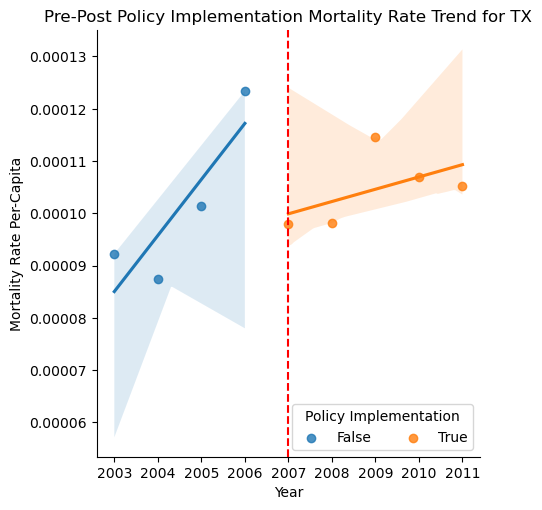

In [12]:
plot = sns.lmplot(
    data=mortality_2[mortality_2["State_Code"] == test_state],
    x="Year",
    y="Mortality_Rate",
    hue="policy_implementation",
    legend=False,
)
plot.set(title=f"Pre-Post Policy Implementation Mortality Rate Trend for {test_state}")

plt.legend(
    loc="lower right",
    # bbox_to_anchor=(0.5, -0.15),
    title="Policy Implementation",
    ncol=2,
)

ax = plot.axes[0, 0]

ax.axvline(policy_year, ls="--", color="red")
ax.set_ylabel("Mortality Rate Per-Capita")

/Users/revanth/miniconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(2.515625000000009, 0.5, 'Mortality Rate Per-Capita')

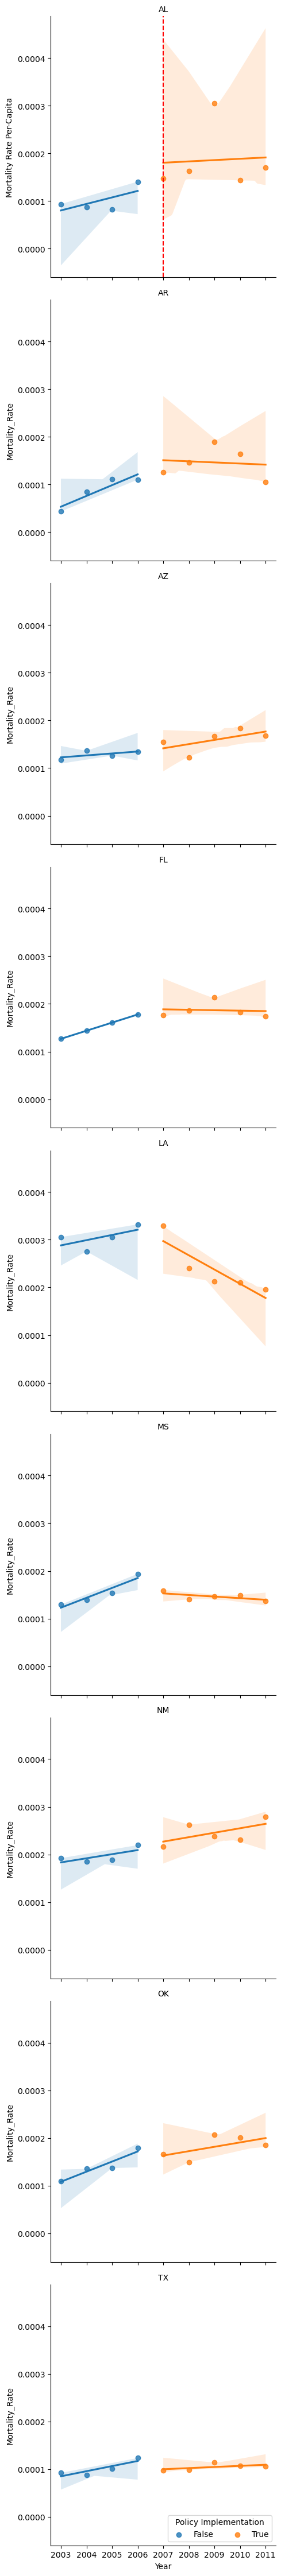

In [13]:
plot = sns.lmplot(
    data=mortality_2,
    x="Year",
    y="Mortality_Rate",
    hue="policy_implementation",
    legend=False,
    row="State_Code",
)

# Set titles for each subplot
plot = plot.set_titles("{row_name}")

plt.legend(
    loc="lower right",
    # bbox_to_anchor=(0.5, -0.15),
    title="Policy Implementation",
    ncol=2,
)

ax = plot.axes[0, 0]

ax.axvline(policy_year, ls="--", color="red")
ax.set_ylabel("Mortality Rate Per-Capita")

In [14]:
mortality_3 = (
    mortality.groupby(["State_Type", "Year", "policy_implementation"])
    .agg({"Mortality_Rate": "mean"})
    .reset_index()
)
mortality_3.sample(5)

,State_Type,Year,policy_implementation,Mortality_Rate
0,Control,2003,False,0.000145
16,Test,2010,True,0.000107
2,Control,2005,False,0.000162
7,Control,2010,True,0.000184
9,Test,2003,False,0.000092


In [15]:
mortality_3["hue_separator"] = (
    mortality_3["State_Type"]
    + " State-"
    + mortality_3["policy_implementation"].astype(str)
)

/Users/revanth/miniconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(-15.234374999999991, 0.5, 'Mortality Rate Per-Capita')

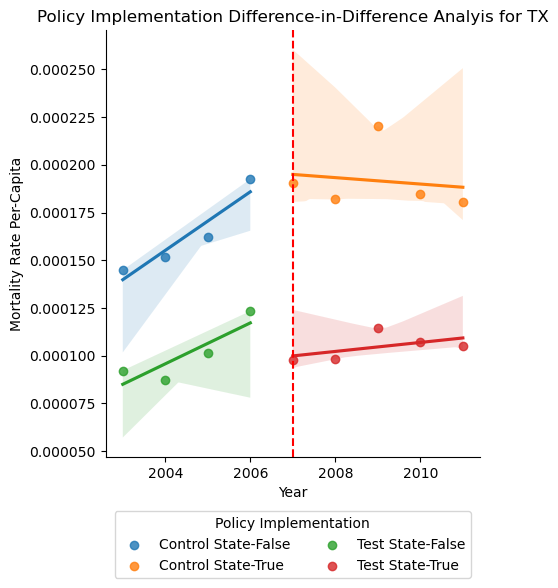

In [16]:
plot = sns.lmplot(
    data=mortality_3,
    x="Year",
    y="Mortality_Rate",
    hue="hue_separator",
    legend=False,
)
plot.set(
    title=f"Policy Implementation Difference-in-Difference Analyis for {test_state}"
)

plt.legend(
    loc="lower center",
    bbox_to_anchor=(0.5, -0.3),
    title="Policy Implementation",
    ncol=2,
)

ax = plot.axes[0, 0]

ax.axvline(policy_year, ls="--", color="red")
ax.set_ylabel("Mortality Rate Per-Capita")

# Trying Different Visualization method to prevent multiple colors in the legend

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


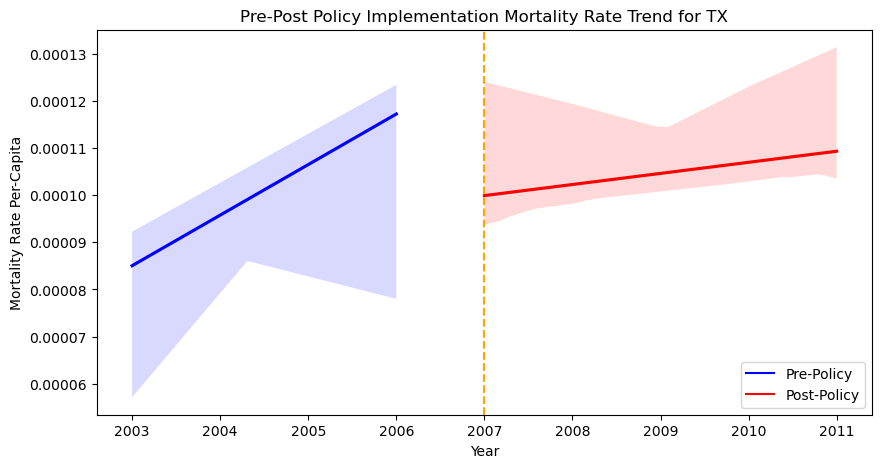

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

# plotting the pre-post graph
color = "red"
sns.regplot(
    data=mortality_2[
        (mortality_2["State_Code"] == test_state)
        & (mortality_2["policy_implementation"] == True)
    ],
    x="Year",
    y="Mortality_Rate",
    line_kws={"color": color},
    ax=ax,
    scatter=False,
)

# plotting the pre-post graph
color = "blue"
sns.regplot(
    data=mortality_2[
        (mortality_2["State_Code"] == test_state)
        & (mortality_2["policy_implementation"] != True)
    ],
    x="Year",
    y="Mortality_Rate",
    line_kws={"color": color},
    ax=ax,
    scatter=False,
)

# adding legends
plt.legend(
    loc="lower right",
    # bbox_to_anchor=(0.5, -0.15),
    title="Policy Implementation",
    ncol=2,
)

# addding vertical line
ax.axvline(policy_year, ls="--", color="orange")

# creating custom legend handles
blue_line = mlines.Line2D([], [], color="blue", label="Pre-Policy")
red_line = mlines.Line2D([], [], color="red", label="Post-Policy")

# adding legends
plt.legend(handles=[blue_line, red_line], loc="lower right")
plt.title(f"Pre-Post Policy Implementation Mortality Rate Trend for {test_state}")
plt.ylabel("Mortality Rate Per-Capita")

plt.savefig(f"../../Plots/{test_state}_pp_mortality.png")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


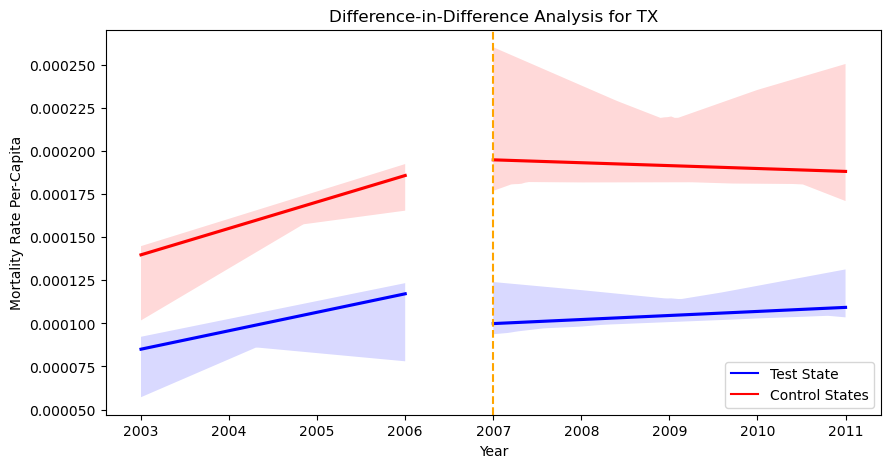

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

# plotting for test state
color = "blue"
sns.regplot(
    data=mortality_3[
        (mortality_3["State_Type"] == "Test")
        & (mortality_3["policy_implementation"] == True)
    ],
    x="Year",
    y="Mortality_Rate",
    line_kws={"color": color},
    ax=ax,
    scatter=False,
)

sns.regplot(
    data=mortality_3[
        (mortality_3["State_Type"] == "Test")
        & (mortality_3["policy_implementation"] != True)
    ],
    x="Year",
    y="Mortality_Rate",
    line_kws={"color": color},
    ax=ax,
    scatter=False,
)

# plotting for control states
color = "red"
sns.regplot(
    data=mortality_3[
        (mortality_3["State_Type"] == "Control")
        & (mortality_3["policy_implementation"] == True)
    ],
    x="Year",
    y="Mortality_Rate",
    line_kws={"color": color},
    ax=ax,
    scatter=False,
)

sns.regplot(
    data=mortality_3[
        (mortality_3["State_Type"] == "Control")
        & (mortality_3["policy_implementation"] != True)
    ],
    x="Year",
    y="Mortality_Rate",
    line_kws={"color": color},
    ax=ax,
    scatter=False,
)
# adding legends
plt.legend(
    loc="lower right",
    # bbox_to_anchor=(0.5, -0.15),
    title="Policy Implementation",
    ncol=2,
)

# addding vertical line
ax.axvline(policy_year, ls="--", color="orange")

# creating custom legend handles
blue_line = mlines.Line2D([], [], color="blue", label="Test State")
red_line = mlines.Line2D([], [], color="red", label="Control States")

# adding legends
plt.legend(handles=[blue_line, red_line], loc="lower right")
plt.title(f"Difference-in-Difference Analysis for {test_state}")
plt.ylabel("Mortality Rate Per-Capita")

plt.savefig(f"../../Plots/{test_state}_did_mortality.png")